# Dog and Cat classification

In [30]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, datetime, shutil, glob
from efficientnet_v2 import EfficientNetV2B0

In [31]:
# load the tensorboard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
CUDA_VISIBLE_DEVICES = 0 # make sure that the GPU is used
METHOD = 2
BATCH_SIZE = 32
IMAGE_SHAPE = 224
# TRAIN_DIR = 'D:/ann_course/train'
# TEST_DIR = 'D:/ann_course/test1'

In [33]:
datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2 # 80% training, 20% validation
)

datagen2 = ImageDataGenerator()

train_data_gen = datagen.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = 'D://ann_course//img//train',
    shuffle = True, # radomly shuffle the data
    # subset = 'training',
    target_size = (IMAGE_SHAPE, IMAGE_SHAPE) # (224, 224)
)

val_data_gen = datagen.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = 'D://ann_course//img//validation',
    shuffle = True,
    # subset = 'validation',
    target_size = (IMAGE_SHAPE, IMAGE_SHAPE)
)

test_data_gen = datagen2.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory ='D://ann_course//test_資料集//test',
    target_size = (IMAGE_SHAPE, IMAGE_SHAPE)
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12480 images belonging to 2 classes.


In [34]:
train_data_gen.class_indices, val_data_gen.class_indices#, test_data_gen.class_indices

({'cat': 0, 'dog': 1}, {'cat': 0, 'dog': 1})

### Build model

In [35]:
def build_model_eff(classes):
    inputs = keras.layers.Input(shape=(224,224, 3))
    base = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, 
                                                                  weights='imagenet',
                                                                  pooling = 'avg')
    base.trainable = False
    features = base(inputs)
    x = tf.keras.layers.Dense(units=4096, activation='relu')(features)
    x = tf.keras.layers.Dropout(.4)(x)
    logits = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs = inputs, outputs = logits, name = "EfficientNetV2B0")
    
    return model

In [36]:
model = build_model_eff(2)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 893217f2bb855e2983157299931e43ff so we will re-download the data.
24274472/24274472 [==============================] - 1s 0us/step


In [37]:
model.summary()

Model: "EfficientNetV2B0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 4096)              5246976   
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 11,174,482
Trainable params: 5,255,170
Non-trainable params: 5,919,312
_______________________________

In [38]:
logdir = os.path.join('D:\\Artificial_Neural_Networks_and_Their_Applications\\tensorboard_logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)

In [39]:
opt = Adam(learning_rate = 0.001)

In [40]:
model.compile(
    optimizer='adam',
    loss = keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [41]:
checkpoint = ModelCheckpoint(
    'effV2B0.h5',
    monitor = 'val_accuracy',
    verbose = 1, # show result every time
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq = 'epoch'
)

### Training

In [42]:
hist = model.fit(
    train_data_gen,
    validation_data = val_data_gen,
    epochs = 20,
    callbacks = [checkpoint, tensorboard_callback]
)

D:\anaconda3\envs\tf2\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
D:\anaconda3\envs\tf2\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9819
Epoch 1: val_accuracy improved from -inf to 0.98520, saving model to effV2B0.h5
625/625 [==============================] - 4691s 7s/step - loss: 0.0679 - accuracy: 0.9819 - val_loss: 0.0643 - val_accuracy: 0.9852
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9859
Epoch 2: val_accuracy improved from 0.98520 to 0.98620, saving model to effV2B0.h5
625/625 [==============================] - 4655s 7s/step - loss: 0.0530 - accuracy: 0.9859 - val_loss: 0.0604 - val_accuracy: 0.9862
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9881
Epoch 3: val_accuracy improved from 0.98620 to 0.98680, saving model to effV2B0.h5
625/625 [==============================] - 4655s 7s/step - loss: 0.0445 - accuracy: 0.9881 - val_loss: 0.0747 - val_accuracy: 0.9868
Epoch 4/20
625/625 [==============================] - ETA: 0s - los

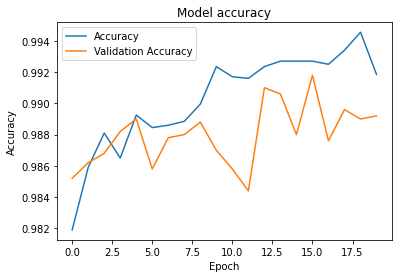

In [43]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy'])

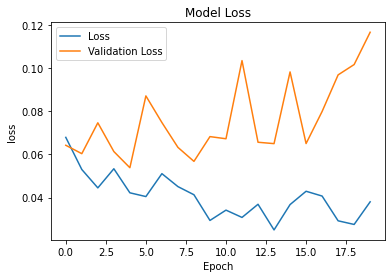

In [44]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation Loss'])

### Testing

In [45]:
from sklearn.metrics import confusion_matrix,classification_report

In [46]:
saved_model = load_model('effV2B0.h5')

In [47]:
dogs = glob.glob(r'D:\ann_course\test_資料集\test\dogs/*.jpg')
cats = glob.glob(r'D:\ann_course\test_資料集\test\cats/*.jpg')

num = len(dogs) + len(cats)
progbar = Progbar(num)
count = 0

y_pred = []
y_test = []

for file in dogs:
    img = load_img(file, target_size = (224, 224))
    img = np.asarray(img)
    img = np.expand_dims(img, axis = 0)
    output = saved_model.predict(img)
    prediction = 1 if output[0][0] > output[0][1] else 0
    y_pred.append(prediction)
    y_test.append(0)
    progbar.update(count)
    count += 1

for file in cats:
    img = load_img(file, target_size = (224, 224))
    img = np.asarray(img)
    img = np.expand_dims(img, axis = 0)
    output = saved_model.predict(img)
    prediction = 1 if output[0][0] > output[0][1] else 0
    y_pred.append(prediction)
    y_test.append(1)
    progbar.update(count)
    count += 1

12479/12480 [============================>.] - ETA: 1s

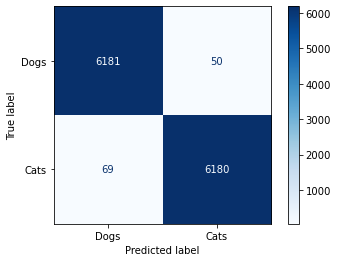

In [48]:
y_pred = np.array(y_pred)
y_test = np.array(y_test)

labels = ['Dogs', 'Cats']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = plt.cm.Blues)

In [49]:
name = ['Dogs', 'Cats']
print(classification_report(y_test,y_pred, target_names = name))

              precision    recall  f1-score   support

        Dogs       0.99      0.99      0.99      6231
        Cats       0.99      0.99      0.99      6249

    accuracy                           0.99     12480
   macro avg       0.99      0.99      0.99     12480
weighted avg       0.99      0.99      0.99     12480



#### Specificity

In [50]:
#TN / TN + FP
#Dog
print(f'Dog\'s Specificity: {round(cm[1][1] / (cm[1][1] + cm[1][0]) * 100, 4)}%')

Dog's Specificity: 98.8958%


In [51]:
print(f'Cat\'s Specificity: {round(cm[0][0] / (cm[0][0] + cm[0][1]) * 100, 4)}%')

Cat's Specificity: 99.1976%
